# Simulation Data Analysis

<div id="toc-wrapper"><h3> Table of Contents </h3><div id="toc" style="max-height: 787px;"><ol class="toc-item"><li><a href="#Globals">Globals</a></li><li><a href="#Plot-Fig.-3A">Plot Fig. 3A</a></li><li><a href="#Plot-Fig.-3B">Plot Fig. 3B</a></li><li><a href="#Plot-Fig.-3C">Plot Fig. 3C</a></li><li><a href="#Plot-Fig.-4">Plot Fig. 4</a></li><li><a href="#Plot-Fig.-4--Figure-supplement-1">Plot Fig. 4--Figure supplement 1</a></li><li><a href="#Plot-Fig.-4--Figure-supplement-1H">Plot Fig. 4--Figure supplement 1H</a></li><li><a href="#Plot-Fig.-5">Plot Fig. 5</a></li><li><a href="#Plot-Fig.-5--Figure-supplement-1">Plot Fig. 5--Figure supplement 1</a></li><li><a href="#Plot-Fig.-5--Figure-supplement-1C">Plot Fig. 5--Figure supplement 1C</a></li><li><a href="#Plot-Fig.-6">Plot Fig. 6</a></li><li><a href="#Plot-Fig.-6--Figure-supplement-1">Plot Fig. 6--Figure supplement 1</a></li><li><a href="#Plot-Fig.-7A-top-panel">Plot Fig. 7A top panel</a></li><li><a href="#Plot-Fig.-7A-bottom-panel">Plot Fig. 7A bottom panel</a></li><li><a href="#Plot-Fig.-7B">Plot Fig. 7B</a></li></ol></div></div>

### Globals


In [1]:
%matplotlib inline

In [2]:
import simulation_utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from customize_matplotlib import clean_axis
from matplotlib.ticker import MaxNLocator, LogLocator
import matplotlib as mpl
import Bio.SeqIO

# default matplotlib customizations
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['figure.subplot.hspace'] = 0.5
mpl.rcParams['figure.subplot.wspace'] = 0.5
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['legend.fontsize'] = 6

modelmarkers = {
    'trafficjam': 'o',
    '5primepreterm': 'd',
    'selpreterm': 's',
}

modelcolors = {
    '5primepreterm': 'red',
    'selpreterm': 'blue',
    'bkgdpreterm': 'violet',
    'trafficjam': 'green',
}

modellabels = {
    '5primepreterm': 'CSAT',
    'selpreterm': 'SAT',
    'bkgdpreterm': 'SAT',
    'trafficjam': 'TJ',
}

# starting yfp sequence for leucine starvation expts
yfp0 = Bio.SeqIO.read('../annotations/simulations/yfp0.fa', 'fasta')
yfp0 = str(yfp0.seq)

leucodonlocation = list()
for position in range(0, len(yfp0), 3):
    currentcodon = yfp0[position:position + 3]
    if currentcodon in ['CTG']:
        leucodonlocation.append(position)

# convert pausecodon + pause location into a string


def get_mutant(row):
    mutant = '_'.join(
        [row['pausecodon'].lower() + pos for pos in row['pauselocation']])
    return mutant


# order codons by their location 5' to 3' in the string created above
def return_mutant_for_ordering(mutant):
    positions = sorted([int(string[3:]) for string in mutant.split('_')])
    return '_'.join([mutant[:3] + str(pos) for pos in positions])


# get number of pauses followed by their location for ordering the double,
# triple and quad mutants
def return_pos_for_ordering(pausepositions):
    positions = [int(loc) for loc in pausepositions]
    return tuple([len(positions)] + positions)


# get interpause distance, followed by the first pause location for
# ordering distance mutants
def return_interpausedistance_for_ordering(pauselocation):
    positions = sorted([int(pos) for pos in pauselocation])
    if len(positions) == 1:
        sortorder = (-1, positions[0])
    else:
        sortorder = (leucodonlocation[positions[1] - 1] -
                     leucodonlocation[positions[0] - 1], positions[0])
    return sortorder

### Plot Fig. 3A

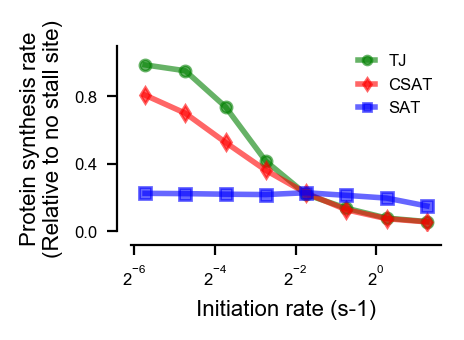

In [3]:
'''
# Uncomment this region if run_simulations_based_on_experiment_fits.ipynb
# was run to generate new simulation data

simulationdata = simulation_utils.get_simulation_data(runnumber=6)

simulationdata.drop(
    ['files'], axis=1).to_csv(
        '../rawdata/simulations/run6_data.tsv', sep='\t', index_label='index')
'''

simulationdata = pd.read_table(
    '../rawdata/simulations/run6_data.tsv', index_col=0)

pretermtypes = ['5primepreterm', 'selpreterm']

fig = plt.figure()
fig.set_size_inches([2, 1.23])
ax = fig.add_subplot(1, 1, 1)

for pretermtype in pretermtypes:
    pretermrates = np.unique(simulationdata[pretermtype])
    for pretermrate in pretermrates:
        fitresults = dict()
        if pretermtype == 'selpreterm' and pretermrate == 0:
            continue
        subset = simulationdata[(simulationdata[pretermtype] == pretermrate)]
        model = pretermtype
        # if pretermrate is 0, make sure all other preterm rates are also 0
        if pretermrate == 0:
            for innerpretermtype in pretermtypes:
                if innerpretermtype == pretermtype:
                    continue
                subset = subset[(subset[innerpretermtype] == 0)]
                model = 'trafficjam'
        subset = subset.sort_values(by=['initiationrate'])
        ax.semilogx(
            subset['initiationrate'],
            subset['ps_ratio'],
            '-',
            label=modellabels[model],
            marker=modelmarkers[model],
            color=modelcolors[model],
            basex=2,
            alpha=0.6,
            markersize=4)

clean_axis(ax)
ax.xaxis.set(major_locator=LogLocator(4))
ax.yaxis.set(major_locator=MaxNLocator(3))
ax.set(ylim=(0, 1.1))
ax.legend(loc=1)
ax.set(
    xlabel=u'Initiation rate (s-1)',
    ylabel='Protein synthesis rate\n(Relative to no stall site)', )
fig.savefig('../figures/fig3a.svg')

### Plot Fig. 3B

/fh/fast/subramaniam_a/user/rasi/virtualenv/default2/lib/python2.7/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


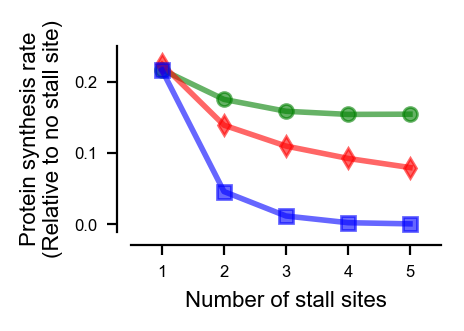

In [4]:
'''
# Uncomment this region if run_simulations_based_on_experiment_fits.ipynb
# was run to generate new simulation data

simulationdata = simulation_utils.get_simulation_data(runnumber=7)

simulationdata.drop(
    ['files'], axis=1).to_csv(
        '../rawdata/simulations/run7_data.tsv', sep='\t', index_label='index')
'''

simulationdata = pd.read_table(
    '../rawdata/simulations/run7_data.tsv', index_col=0)

def reorder_codons(mutant):
    positions = [int(string[3:]) for string in mutant.split('_')]
    codons = [string[:3] for string in mutant.split('_')]
    positions = [positions[x] for x in np.argsort(positions)]
    codons = [codons[x] for x in np.argsort(positions)]
    return '_'.join(codon + str(position)
                    for codon, position in zip(codons, positions))


def return_mutant_for_ordering(mutant):
    positions = [int(string[3:]) for string in mutant.split('_')]
    return tuple([len(mutant.split('_'))] + positions)


pretermtypes = ['5primepreterm', 'selpreterm']

fig = plt.figure()
fig.set_size_inches([2, 1.23])
ax = fig.add_subplot(1, 1, 1)

for pretermtype in pretermtypes:
    pretermrates = np.unique(simulationdata[pretermtype])
    for pretermrate in pretermrates:
        fitresults = dict()
        if pretermtype == 'selpreterm' and pretermrate == 0:
            continue
        subset = simulationdata[(simulationdata[pretermtype] == pretermrate)]
        model = pretermtype
        # if pretermrate is 0, make sure all other preterm rates are also 0
        if pretermrate == 0:
            for innerpretermtype in pretermtypes:
                if innerpretermtype == pretermtype:
                    continue
                subset = subset[(subset[innerpretermtype] == 0)]
                model = 'trafficjam'
        subset['mutant'] = subset['mutant'].apply(
            lambda mutant: reorder_codons(mutant))
        subset = subset[subset['mutant'].apply(
            lambda x: x.find('cta2') != -1)]  # get rid of no-stall control
        subset['numberofstalls'] = subset['mutant'].apply(
            lambda x: len(x.split('_')))
        subset = subset.set_index('mutant')
        sortedindices = sorted(subset.index, key=return_mutant_for_ordering)
        subset = subset.ix[sortedindices]
        ax.plot(
            subset['numberofstalls'],
            subset['ps_ratio'],
            '-',
            label=modellabels[model],
            marker=modelmarkers[model],
            color=modelcolors[model],
            alpha=0.6,
            markersize=5)

clean_axis(ax)
ax.xaxis.set(major_locator=MaxNLocator(5))
ax.yaxis.set(major_locator=MaxNLocator(3))
ax.set(xlim=(0.5, subset['numberofstalls'].max() + 0.5), ylim=(-0.01, 0.25))
ax.set(
    xlabel='Number of stall sites',
    ylabel='Protein synthesis rate\n(Relative to no stall site)', )
fig.savefig('../figures/fig3b.svg')

### Plot Fig. 3C

/fh/fast/subramaniam_a/user/rasi/virtualenv/default2/lib/python2.7/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


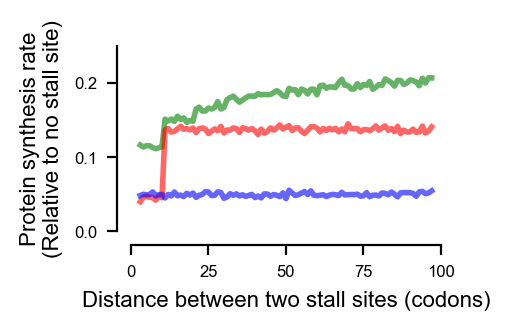

In [5]:
'''
# Uncomment this region if run_simulations_based_on_experiment_fits.ipynb
# was run to generate new simulation data

simulationdata = simulation_utils.get_simulation_data(runnumber=8)

simulationdata.drop(
    ['files'], axis=1).to_csv(
        '../rawdata/simulations/run8_data.tsv', sep='\t', index_label='index')
'''

simulationdata = pd.read_table(
    '../rawdata/simulations/run8_data.tsv', index_col=0)

pretermtypes = ['5primepreterm', 'selpreterm']

fig = plt.figure()
fig.set_size_inches([2, 1.23])
ax = fig.add_subplot(1, 1, 1)

for pretermtype in pretermtypes:
    pretermrates = np.unique(simulationdata[pretermtype])
    for pretermrate in pretermrates:
        fitresults = dict()
        if pretermtype == 'selpreterm' and pretermrate == 0:
            continue
        subset = simulationdata[(simulationdata[pretermtype] == pretermrate)]
        model = pretermtype
        # if pretermrate is 0, make sure all other preterm rates are also 0
        if pretermrate == 0:
            for innerpretermtype in pretermtypes:
                if innerpretermtype == pretermtype:
                    continue
                subset = subset[(subset[innerpretermtype] == 0)]
                model = 'trafficjam'
        subset['stalllocation'] = subset['mutant'].apply(lambda x: int(x[3:]))
        subset = subset[subset['stalllocation'] > 59]
        subset = subset[subset['stalllocation'] < 159]
        sortedindices = sorted(
            subset.index, key=lambda x: subset.ix[x]['stalllocation'])
        subset = subset.ix[sortedindices]
        subset = subset[2:-2]
        ax.plot(
            subset['stalllocation'] - 59,
            subset['ps_ratio'],
            '-',
            label=modellabels[model],
            marker=None,
            color=modelcolors[model],
            alpha=0.6)

clean_axis(ax)
ax.set(xlim=(0, 100), ylim=(0, 0.25))
ax.xaxis.set(major_locator=MaxNLocator(4))
ax.yaxis.set(major_locator=MaxNLocator(3))
ax.set(
    xlabel='Distance between two stall sites (codons)',
    ylabel='Protein synthesis rate\n(Relative to no stall site)', )
fig.savefig('../figures/fig3c.svg')

### Plot Fig. 4

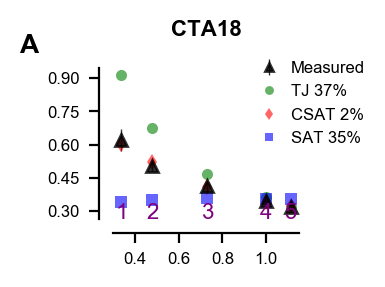

In [6]:
mutants = ['cta18' '', '', '', '', '']

'''
# Uncomment this region if run_simulations_based_on_experiment_fits.ipynb
# was run to generate new simulation data

simulationdata = simulation_utils.get_simulation_data(runnumber=3)

simulationdata.drop(
    ['files'], axis=1).to_csv(
        '../rawdata/simulations/run3_data.tsv', sep='\t', index_label='index')
'''

simulationdata = pd.read_table(
    '../rawdata/simulations/run3_data.tsv', index_col=0)

pretermtypes = ['5primepreterm', 'selpreterm']

fig = plt.figure()
fig.set_size_inches([3 * 2, 2 * (len(mutants) + 2) / 2])
fig.subplots_adjust(wspace=1, hspace=1)

panellabels = iter(['A', 'A', 'B', 'C', 'D', 'E', 'F', 'G'])
axcount = 0
for mutant in mutants[:1]:
    rmserror = dict()
    axcount += 1
    ax = fig.add_subplot(2 * (len(mutants) + 1) / 3, 3, axcount)

    summarydata = pd.read_table(
        '../processeddata/platereader/measured_yfprates_' + mutant +
        '_initiation_mutants.tsv')
    summarydata = summarydata.sort_values(by='richrate_mean')

    for pretermtype in pretermtypes:
        pretermrates = np.unique(simulationdata[pretermtype])
        for pretermrate in pretermrates:
            fitresults = dict()
            if pretermtype == 'selpreterm' and pretermrate == 0:
                continue
            subset = simulationdata[(simulationdata[pretermtype] == pretermrate
                                     ) & (simulationdata['mutant'] == mutant)]
            model = pretermtype
            # if pretermrate is 0, make sure all other preterm rates are also 0
            if pretermrate == 0:
                for innerpretermtype in pretermtypes:
                    if innerpretermtype == pretermtype:
                        continue
                    subset = subset[(subset[innerpretermtype] == 0)]
                    model = 'trafficjam'
            subset = subset.sort_values(by=['initiationrate'])
            # divide by the second highest initiation rate, this is the wt rbs
            subset['initiationrate'] /= np.unique(
                simulationdata['initiationrate'])[-2]

            if mutant == 'cta6':
                # the 'ATC' start codon variant was not cloned for the 'CTA6' variant
                subset = subset.reset_index().ix[[0, 2, 3, 4]]

            # exclude the fitted wt RBS for calculating error
            predicted = np.delete(np.array(subset['ps_ratio']), -2)
            measured = np.delete(np.array(summarydata['starverate_mean']), -2)
            rmserror[model] = int(
                np.sqrt(mean_squared_error(measured, predicted)) /
                measured.mean() * 100)

            ax.plot(
                subset['initiationrate'],
                subset['ps_ratio'],
                marker=modelmarkers[model],
                linestyle='None',
                markerfacecolor=modelcolors[model],
                alpha=0.6,
                markeredgecolor='None',
                label=modellabels[model] + " %d%%" % rmserror[model])

    ax.errorbar(
        x=subset['initiationrate'],
        y=summarydata['starverate_mean'],
        yerr=summarydata['starverate_err'],
        marker='^',
        linestyle='None',
        color='black',
        linewidth=0.5,
        markeredgecolor='black',
        label='Measured',
        alpha=0.8)
    if axcount == 7:
        ax.set(xlabel='YFP synthesis rate\n(Leu-Rich)',
               ylabel='YFP synthesis rate\n(Relative to no stall site)')
    clean_axis(ax)
    ax.yaxis.set(major_locator=MaxNLocator(5))
    ax.xaxis.set(major_locator=MaxNLocator(5))
    handles, legendlabels = ax.get_legend_handles_labels()
    handles = [handles[n] for n in [3, 0, 1, 2]]
    legendlabels = [legendlabels[n] for n in [3, 0, 1, 2]]
    ax.legend(handles, legendlabels, loc=1, bbox_to_anchor=(1.4, 1.1))
    for loop, x in enumerate(subset['initiationrate']):
        if mutant == 'cta06' and loop:  # teh variant 2 'ATC' is not there
            ax.text(
                x,
                ax.get_ylim()[0],
                str(loop + 2),
                ha='center',
                color='purple')
        else:
            ax.text(
                x,
                ax.get_ylim()[0],
                str(loop + 1),
                ha='center',
                color='purple')
    ax.set_title(mutant.replace('06', '6').upper(), y=1.1)
    ax.text(
        -0.5,
        1.1,
        panellabels.next(),
        weight='bold',
        transform=ax.transAxes,
        fontsize='large')

fig.savefig('../figures/fig4.svg')

### Plot Fig. 4--Figure supplement 1

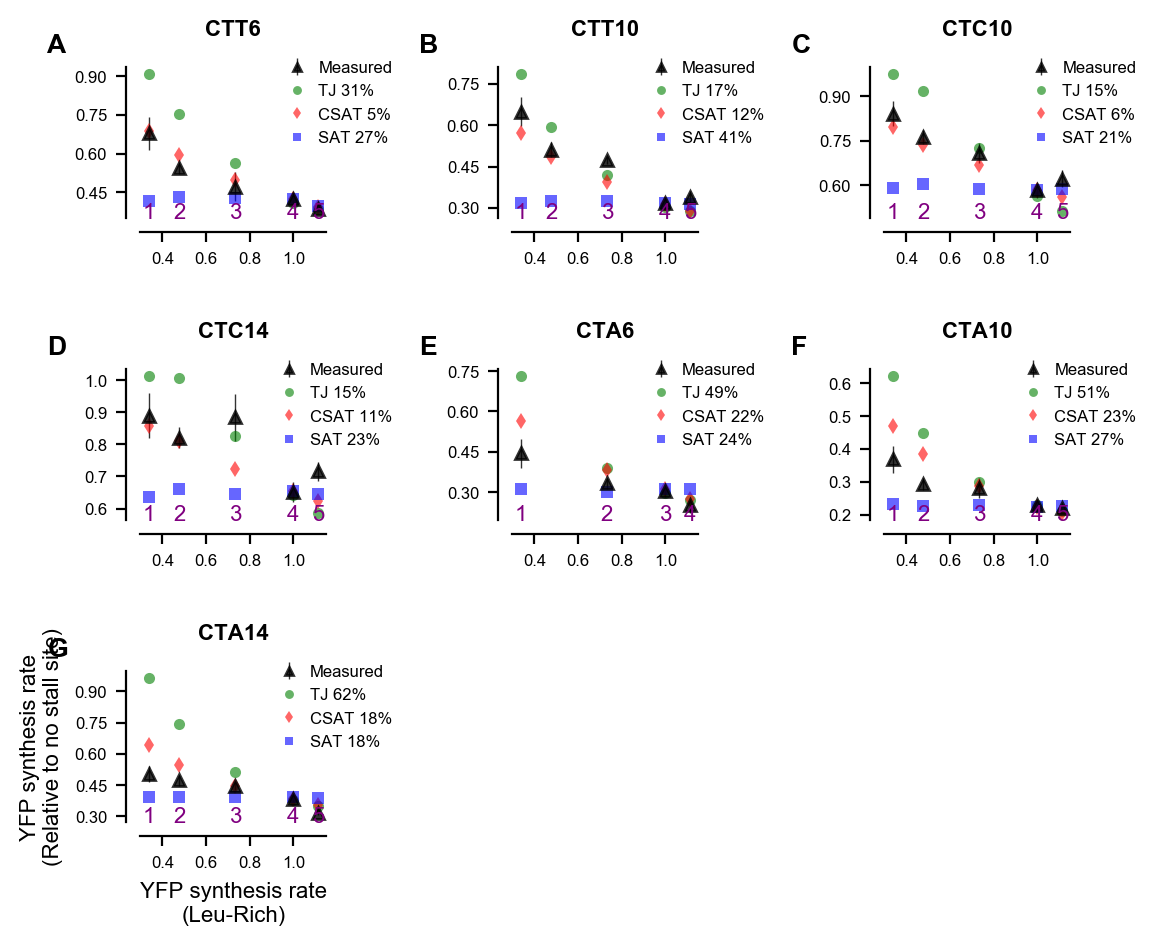

In [7]:
mutants = [
    'ctt6',
    'ctt10',
    'ctc10',
    'ctc14',
    'cta6',
    'cta10',
    'cta14',
]

'''
# Uncomment this region if run_simulations_based_on_experiment_fits.ipynb
# was run to generate new simulation data

simulationdata = simulation_utils.get_simulation_data(runnumber=3)
'''

simulationdata = pd.read_table(
    '../rawdata/simulations/run3_data.tsv', index_col=0)
pretermtypes = ['5primepreterm', 'selpreterm']

fig = plt.figure()
fig.set_size_inches([3 * 2, 2 * (len(mutants) + 2) / 2])
fig.subplots_adjust(wspace=1, hspace=1)

panellabels = iter(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
axcount = 0
for mutant in mutants:
    rmserror = dict()
    axcount += 1
    ax = fig.add_subplot(2 * (len(mutants) + 1) / 3, 3, axcount)

    summarydata = pd.read_table(
        '../processeddata/platereader/measured_yfprates_' + mutant +
        '_initiation_mutants.tsv')
    summarydata = summarydata.sort_values(by='richrate_mean')

    for pretermtype in pretermtypes:
        pretermrates = np.unique(simulationdata[pretermtype])
        for pretermrate in pretermrates:
            fitresults = dict()
            if pretermtype == 'selpreterm' and pretermrate == 0:
                continue
            subset = simulationdata[(simulationdata[pretermtype] == pretermrate
                                     ) & (simulationdata['mutant'] == mutant)]
            model = pretermtype
            # if pretermrate is 0, make sure all other preterm rates are also 0
            if pretermrate == 0:
                for innerpretermtype in pretermtypes:
                    if innerpretermtype == pretermtype:
                        continue
                    subset = subset[(subset[innerpretermtype] == 0)]
                    model = 'trafficjam'
            subset = subset.sort_values(by=['initiationrate'])
            # divide by the second highest initiation rate, this is the wt rbs
            subset['initiationrate'] /= np.unique(
                simulationdata['initiationrate'])[-2]

            if mutant == 'cta6':
                # the 'ATC' start codon variant was not cloned for the 'CTA6' variant
                subset = subset.reset_index().ix[[0, 2, 3, 4]]

            # exclude the fitted wt RBS for calculating error
            predicted = np.delete(np.array(subset['ps_ratio']), -2)
            measured = np.delete(np.array(summarydata['starverate_mean']), -2)
            rmserror[model] = int(
                np.sqrt(mean_squared_error(measured, predicted)) /
                measured.mean() * 100)

            ax.plot(
                subset['initiationrate'],
                subset['ps_ratio'],
                marker=modelmarkers[model],
                linestyle='None',
                markerfacecolor=modelcolors[model],
                alpha=0.6,
                markeredgecolor='None',
                label=modellabels[model] + " %d%%" % rmserror[model])

    ax.errorbar(
        x=subset['initiationrate'],
        y=summarydata['starverate_mean'],
        yerr=summarydata['starverate_err'],
        marker='^',
        linestyle='None',
        color='black',
        linewidth=0.5,
        markeredgecolor='black',
        label='Measured',
        alpha=0.8)
    if axcount == 7:
        ax.set(xlabel='YFP synthesis rate\n(Leu-Rich)',
               ylabel='YFP synthesis rate\n(Relative to no stall site)')
    clean_axis(ax)
    ax.yaxis.set(major_locator=MaxNLocator(5))
    ax.xaxis.set(major_locator=MaxNLocator(5))
    handles, legendlabels = ax.get_legend_handles_labels()
    handles = [handles[n] for n in [3, 0, 1, 2]]
    legendlabels = [legendlabels[n] for n in [3, 0, 1, 2]]
    ax.legend(handles, legendlabels, loc=1, bbox_to_anchor=(1.4, 1.1))
    for loop, x in enumerate(subset['initiationrate']):
        if mutant == 'cta06' and loop:  # teh variant 2 'ATC' is not there
            ax.text(
                x,
                ax.get_ylim()[0],
                str(loop + 2),
                ha='center',
                color='purple')
        else:
            ax.text(
                x,
                ax.get_ylim()[0],
                str(loop + 1),
                ha='center',
                color='purple')
    ax.set_title(mutant.replace('06', '6').upper(), y=1.1)
    ax.text(
        -0.5,
        1.1,
        panellabels.next(),
        weight='bold',
        transform=ax.transAxes,
        fontsize='large')

fig.savefig('../figures/fig4_s1ag.svg')

### Plot Fig. 4--Figure supplement 1H

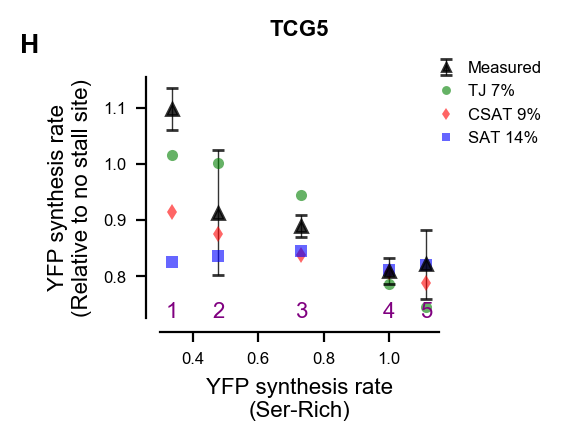

In [8]:
mutants = ['tcg5', '', '', '']

'''
# Uncomment this region if run_simulations_based_on_experiment_fits.ipynb
# was run to generate new simulation data

simulationdata = simulation_utils.get_simulation_data(runnumber=14)

simulationdata.drop(
    ['files'], axis=1).to_csv(
        '../rawdata/simulations/run14_data.tsv', sep='\t', index_label='index')
'''

simulationdata = pd.read_table(
    '../rawdata/simulations/run14_data.tsv', index_col=0)

pretermtypes = ['5primepreterm', 'selpreterm']

fig = plt.figure()
fig.set_size_inches([3 * 3, 5 * (len(mutants) + 1) / 3])
fig.subplots_adjust(wspace=1, hspace=1)

panellabels = iter(['H', '', ''])
axcount = 0
for mutant in mutants[:-3]:
    rmserror = dict()
    axcount += 1
    ax = fig.add_subplot(2 * (len(mutants) + 1) / 3, 3, axcount)

    summarydata = pd.read_table(
        '../processeddata/platereader/measured_yfprates_' + mutant +
        '_initiation_mutants.tsv')
    summarydata = summarydata.set_index('initiation_variant')
    # order by increasing initiation rate
    summarydata = summarydata.ix[['TTG', 'ATC', 'RBS2', 'wt', 'RBS4']]

    for pretermtype in pretermtypes:
        pretermrates = np.unique(simulationdata[pretermtype])
        for pretermrate in pretermrates:
            fitresults = dict()
            if pretermtype == 'selpreterm' and pretermrate == 0:
                continue
            subset = simulationdata[(simulationdata[pretermtype] == pretermrate
                                     ) & (simulationdata['mutant'] == mutant)]
            model = pretermtype
            # if pretermrate is 0, make sure all other preterm rates are also 0
            if pretermrate == 0:
                for innerpretermtype in pretermtypes:
                    if innerpretermtype == pretermtype:
                        continue
                    subset = subset[(subset[innerpretermtype] == 0)]
                    model = 'trafficjam'
            subset = subset.sort_values(by=['initiationrate'])
            # divide by the second highest initiation rate, this is the wt rbs
            subset['initiationrate'] /= np.unique(
                simulationdata['initiationrate'])[-2]

            predicted = np.array(subset['ps_ratio'])
            measured = np.array(summarydata['starverate_mean'])
            rmserror[model] = int(
                np.sqrt(mean_squared_error(measured, predicted)) /
                measured.mean() * 100)

            ax.plot(
                subset['initiationrate'],
                subset['ps_ratio'],
                marker=modelmarkers[model],
                linestyle='None',
                markerfacecolor=modelcolors[model],
                alpha=0.6,
                markeredgecolor='None',
                label=modellabels[model] + " %d%%" % rmserror[model])

    ax.errorbar(
        x=subset['initiationrate'],
        y=summarydata['starverate_mean'],
        yerr=summarydata['starverate_err'],
        capsize=2,
        marker='^',
        linestyle='None',
        color='black',
        linewidth=0.5,
        markeredgecolor='black',
        label='Measured',
        alpha=0.8)

    ax.set(xlabel='YFP synthesis rate\n(Ser-Rich)',
           ylabel='YFP synthesis rate\n(Relative to no stall site)')
    clean_axis(ax)
    ax.yaxis.set(major_locator=MaxNLocator(5))
    ax.xaxis.set(major_locator=MaxNLocator(5))
    handles, legendlabels = ax.get_legend_handles_labels()
    handles = [handles[n] for n in [3, 0, 1, 2]]
    legendlabels = [legendlabels[n] for n in [3, 0, 1, 2]]
    ax.legend(handles, legendlabels, loc=1, bbox_to_anchor=(1.4, 1.1))
    for loop, x in enumerate(subset['initiationrate']):
        ax.text(
            x, ax.get_ylim()[0], str(loop + 1), ha='center', color='purple')
    ax.set_title(mutant.upper(), y=1.1)
    ax.text(
        -0.5,
        1.1,
        panellabels.next(),
        weight='bold',
        transform=ax.transAxes,
        fontsize='large')

fig.savefig('../figures/fig4_s1h.svg')

### Plot Fig. 5

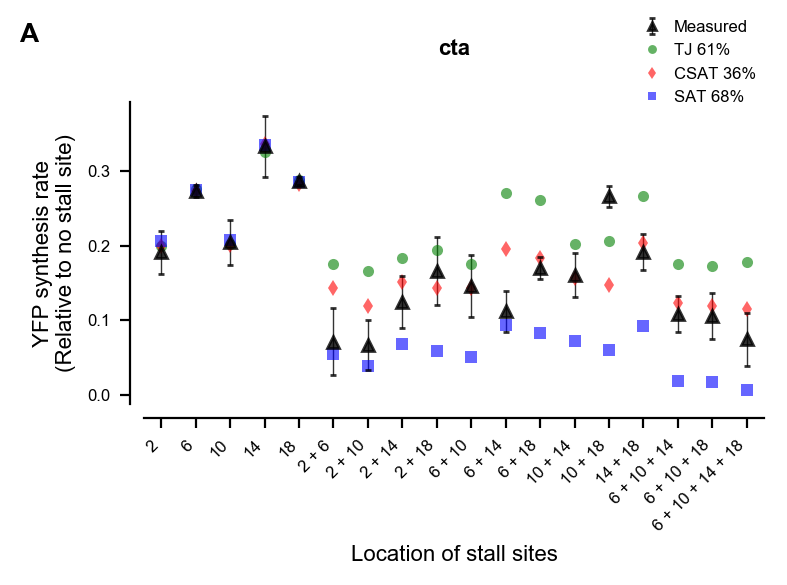

In [9]:
mutants = ['cta', '']

'''
# Uncomment this region if run_simulations_based_on_experiment_fits.ipynb
# was run to generate new simulation data

simulationdata = simulation_utils.get_simulation_data(runnumber=16)

simulationdata.drop(
    ['files'], axis=1).to_csv(
        '../rawdata/simulations/run16_data.tsv', sep='\t', index_label='index')
'''

simulationdata = pd.read_table(
    '../rawdata/simulations/run16_data.tsv', index_col=0)

pretermtypes = ['5primepreterm', 'selpreterm']


def return_pos_for_ordering(pausepositions):
    positions = [int(loc) for loc in pausepositions]
    return tuple([len(positions)] + positions)


def return_mutant_for_ordering(mutant):
    positions = sorted([int(string[3:]) for string in mutant.split('_')])
    return '_'.join([mutant[:3] + str(pos) for pos in positions])


fig = plt.figure()
fig.set_size_inches([4, 3 * len(mutants)])
fig.subplots_adjust(wspace=1, hspace=1)

panellabels = iter(['A', 'B'])
axcount = 0
for mutant in mutants[:-1]:
    rmserror = dict()
    axcount += 1
    ax = fig.add_subplot(len(mutants), 1, axcount)

    summarydata = pd.read_table(
        '../processeddata/platereader/measured_yfprates_' + mutant +
        '_multiple_mutants.tsv')
    summarydata['pauselocation'] = summarydata['pauselocation'].apply(
        lambda x: x.split(','))
    summarydata['sortcolumn'] = summarydata['pauselocation'].apply(
        return_pos_for_ordering)
    summarydata['mutant'] = summarydata.apply(get_mutant, axis=1)
    summarydata = summarydata.sort_values(by=['sortcolumn'])
    summarydata = summarydata.set_index('mutant')

    # make xtick labels nice
    xticklabels = []
    for location in summarydata['pauselocation']:
        xticklabels.append(' + '.join(sorted(location, key=int)))

    for pretermtype in pretermtypes:
        pretermrates = np.unique(simulationdata[pretermtype])
        for pretermrate in pretermrates:
            fitresults = dict()
            if pretermtype == 'selpreterm' and pretermrate == 0:
                continue
            subset = simulationdata[(simulationdata[
                pretermtype] == pretermrate) & (simulationdata['mutant'].apply(
                    lambda string: string.find(mutant.lower()) != -1))]
            model = pretermtype
            # if pretermrate is 0, make sure all other preterm rates are also 0
            if pretermrate == 0:
                for innerpretermtype in pretermtypes:
                    if innerpretermtype == pretermtype:
                        continue
                    subset = subset[(subset[innerpretermtype] == 0)]
                    model = 'trafficjam'
            subset = subset.set_index('mutant')
            subset.index = map(return_mutant_for_ordering, subset.index)
            subset = subset.ix[summarydata.index]
            predicted = np.array(subset['ps_ratio'])[5:]
            measured = np.array(summarydata['starverate_mean'])[5:]
            rmserror[model] = int(
                np.sqrt(mean_squared_error(measured, predicted)) /
                measured.mean() * 100)

            ax.plot(
                np.arange(
                    len(subset)),  # no simulation data for No Stall control
                subset['ps_ratio'],
                marker=modelmarkers[model],
                linestyle='None',
                markerfacecolor=modelcolors[model],
                alpha=0.6,
                markeredgecolor='None',
                label=modellabels[model] + " %d%%" % rmserror[model])

    ax.errorbar(
        x=np.arange(len(summarydata)),
        y=summarydata['starverate_mean'],
        yerr=summarydata[('starverate_err')],
        marker='^',
        linestyle='None',
        color='black',
        linewidth=0.5,
        markeredgecolor='black',
        label='Measured',
        alpha=0.8,
        capsize=1.0, )
    ax.set(xlabel='Location of stall sites',
           ylabel='YFP synthesis rate\n(Relative to no stall site)')
    clean_axis(ax)
    ax.yaxis.set(major_locator=MaxNLocator(5))
    ax.set_xlim(left=-0.5, right=len(summarydata) - 0.5)
    ax.set_xticks(np.arange(len(summarydata)))
    ax.set_xticklabels(
        xticklabels,
        rotation=45,
        ha='right', )
    handles, legendlabels = ax.get_legend_handles_labels()
    handles = [handles[n] for n in [3, 0, 1, 2]]
    legendlabels = [legendlabels[n] for n in [3, 0, 1, 2]]
    ax.legend(handles, legendlabels, loc=1, bbox_to_anchor=(1, 1.3))
    ax.set_title(mutant, y=1.1, weight='bold')
    ax.text(
        -0.2,
        1.2,
        panellabels.next(),
        weight='bold',
        transform=ax.transAxes,
        fontsize='large')

fig.savefig('../figures/fig5.svg')

### Plot Fig. 5--Figure supplement 1

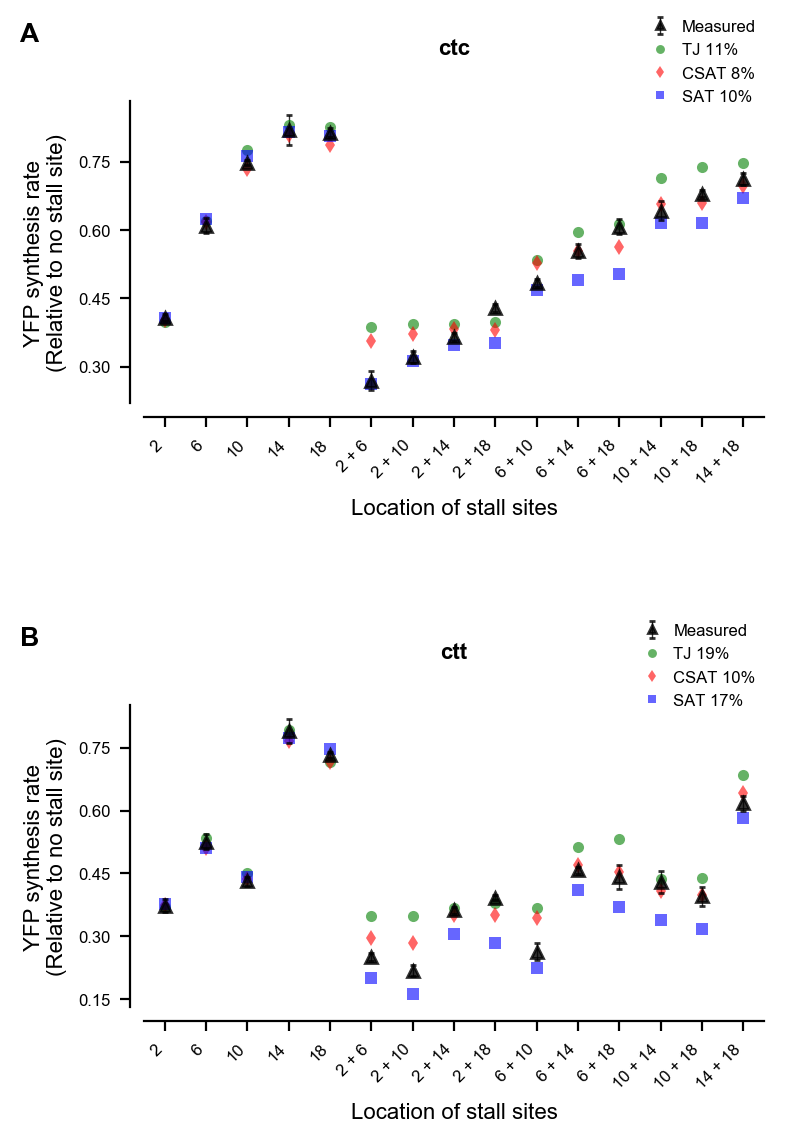

In [10]:
mutants = ['ctc', 'ctt']

'''
# Uncomment this region if run_simulations_based_on_experiment_fits.ipynb
# was run to generate new simulation data

simulationdata = simulation_utils.get_simulation_data(runnumber=4)

simulationdata.drop(
    ['files'], axis=1).to_csv(
        '../rawdata/simulations/run4_data.tsv', sep='\t', index_label='index')
'''

simulationdata = pd.read_table(
    '../rawdata/simulations/run4_data.tsv', index_col=0)

pretermtypes = ['5primepreterm', 'selpreterm']

fig = plt.figure()
fig.set_size_inches([4, 3 * len(mutants)])
fig.subplots_adjust(wspace=1, hspace=1)

panellabels = iter(['A', 'B'])
axcount = 0
for mutant in mutants:
    rmserror = dict()
    axcount += 1
    ax = fig.add_subplot(len(mutants), 1, axcount)

    summarydata = pd.read_table(
        '../processeddata/platereader/measured_yfprates_' + mutant +
        '_double_mutants.tsv')
    summarydata['pauselocation'] = summarydata['pauselocation'].apply(
        lambda x: x.split(','))
    summarydata['sortcolumn'] = summarydata['pauselocation'].apply(
        return_pos_for_ordering)
    summarydata['mutant'] = summarydata.apply(get_mutant, axis=1)
    summarydata = summarydata.sort_values(by=['sortcolumn'])
    summarydata = summarydata.set_index('mutant')

    # make xtick labels nice
    xticklabels = []
    for location in summarydata['pauselocation']:
        xticklabels.append(' + '.join(sorted(location, key=int)))

    for pretermtype in pretermtypes:
        pretermrates = np.unique(simulationdata[pretermtype])
        for pretermrate in pretermrates:
            fitresults = dict()
            if pretermtype == 'selpreterm' and pretermrate == 0:
                continue
            subset = simulationdata[(simulationdata[
                pretermtype] == pretermrate) & (simulationdata['mutant'].apply(
                    lambda string: string.find(mutant.lower()) != -1))]
            model = pretermtype
            # if pretermrate is 0, make sure all other preterm rates are also 0
            if pretermrate == 0:
                for innerpretermtype in pretermtypes:
                    if innerpretermtype == pretermtype:
                        continue
                    subset = subset[(subset[innerpretermtype] == 0)]
                    model = 'trafficjam'
            subset = subset.set_index('mutant')
            subset.index = map(return_mutant_for_ordering, subset.index)
            subset = subset.ix[summarydata.index]
            predicted = np.array(subset['ps_ratio'])[5:]
            measured = np.array(summarydata['starverate_mean'])[5:]
            rmserror[model] = int(
                np.sqrt(mean_squared_error(measured, predicted)) /
                measured.mean() * 100)

            ax.plot(
                np.arange(
                    len(subset)),  # no simulation data for No Stall control
                subset['ps_ratio'],
                marker=modelmarkers[model],
                linestyle='None',
                markerfacecolor=modelcolors[model],
                alpha=0.6,
                markeredgecolor='None',
                label=modellabels[model] + " %d%%" % rmserror[model])

    ax.errorbar(
        x=np.arange(len(summarydata)),
        y=summarydata['starverate_mean'],
        yerr=summarydata[('starverate_err')],
        marker='^',
        linestyle='None',
        color='black',
        linewidth=0.5,
        markeredgecolor='black',
        label='Measured',
        alpha=0.8,
        capsize=1.0, )
    ax.set(xlabel='Location of stall sites',
           ylabel='YFP synthesis rate\n(Relative to no stall site)')
    clean_axis(ax)
    ax.yaxis.set(major_locator=MaxNLocator(5))
    ax.set_xlim(left=-0.5, right=len(summarydata) - 0.5)
    ax.set_xticks(np.arange(len(summarydata)))
    ax.set_xticklabels(
        xticklabels,
        rotation=45,
        ha='right', )
    handles, legendlabels = ax.get_legend_handles_labels()
    handles = [handles[n] for n in [3, 0, 1, 2]]
    legendlabels = [legendlabels[n] for n in [3, 0, 1, 2]]
    ax.legend(handles, legendlabels, loc=1, bbox_to_anchor=(1, 1.3))
    ax.set_title(mutant, y=1.1, weight='bold')
    ax.text(
        -0.2,
        1.2,
        panellabels.next(),
        weight='bold',
        transform=ax.transAxes,
        fontsize='large')

fig.savefig('../figures/fig5_s1ab.svg')

### Plot Fig. 5--Figure supplement 1C

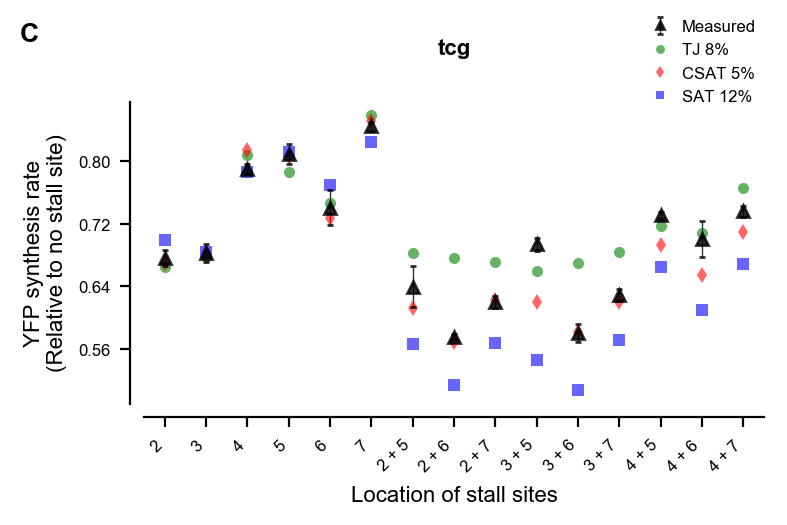

In [11]:
mutants = ['tcg', '']

'''
# Uncomment this region if run_simulations_based_on_experiment_fits.ipynb
# was run to generate new simulation data

simulationdata = simulation_utils.get_simulation_data(runnumber=15)

simulationdata.drop(
    ['files'], axis=1).to_csv(
        '../rawdata/simulations/run15_data.tsv', sep='\t', index_label='index')
'''

simulationdata = pd.read_table(
    '../rawdata/simulations/run15_data.tsv', index_col=0)

pretermtypes = ['5primepreterm', 'selpreterm']

fig = plt.figure()
fig.set_size_inches([4, 3 * len(mutants)])
fig.subplots_adjust(wspace=1, hspace=1)

panellabels = iter(['C', ''])
axcount = 0
for mutant in mutants[:-1]:
    rmserror = dict()
    axcount += 1
    ax = fig.add_subplot(len(mutants), 1, axcount)

    summarydata = pd.read_table(
        '../processeddata/platereader/measured_yfprates_' + mutant +
        '_double_mutants.tsv')
    summarydata['pauselocation'] = summarydata['pauselocation'].apply(
        lambda x: x.split(','))
    summarydata['sortcolumn'] = summarydata['pauselocation'].apply(
        return_pos_for_ordering)
    summarydata['mutant'] = summarydata.apply(get_mutant, axis=1)
    summarydata = summarydata.sort_values(by=['sortcolumn'])
    summarydata = summarydata.set_index('mutant')

    # make xtick labels nice
    xticklabels = []
    for location in summarydata['pauselocation']:
        xticklabels.append(' + '.join(sorted(location, key=int)))

    for pretermtype in pretermtypes:
        pretermrates = np.unique(simulationdata[pretermtype])
        for pretermrate in pretermrates:
            fitresults = dict()
            if pretermtype == 'selpreterm' and pretermrate == 0:
                continue
            subset = simulationdata[(simulationdata[
                pretermtype] == pretermrate) & (simulationdata['mutant'].apply(
                    lambda string: string.find(mutant.lower()) != -1))]
            model = pretermtype
            # if pretermrate is 0, make sure all other preterm rates are also 0
            if pretermrate == 0:
                for innerpretermtype in pretermtypes:
                    if innerpretermtype == pretermtype:
                        continue
                    subset = subset[(subset[innerpretermtype] == 0)]
                    model = 'trafficjam'
            subset = subset.set_index('mutant')
            subset.index = map(return_mutant_for_ordering, subset.index)
            subset = subset.ix[summarydata.index]
            predicted = np.array(subset['ps_ratio'])[6:]
            measured = np.array(summarydata['starverate_mean'])[6:]
            rmserror[model] = int(
                np.sqrt(mean_squared_error(measured, predicted)) /
                measured.mean() * 100)

            ax.plot(
                np.arange(
                    len(subset)),  # no simulation data for No Stall control
                subset['ps_ratio'],
                marker=modelmarkers[model],
                linestyle='None',
                markerfacecolor=modelcolors[model],
                alpha=0.6,
                markeredgecolor='None',
                label=modellabels[model] + " %d%%" % rmserror[model])

    ax.errorbar(
        x=np.arange(len(summarydata)),
        y=summarydata['starverate_mean'],
        yerr=summarydata[('starverate_err')],
        marker='^',
        linestyle='None',
        color='black',
        linewidth=0.5,
        markeredgecolor='black',
        label='Measured',
        alpha=0.8,
        capsize=1.0, )
    ax.set(xlabel='Location of stall sites',
           ylabel='YFP synthesis rate\n(Relative to no stall site)')
    clean_axis(ax)
    ax.yaxis.set(major_locator=MaxNLocator(5))
    ax.set_xlim(left=-0.5, right=len(summarydata) - 0.5)
    ax.set_xticks(np.arange(len(summarydata)))
    ax.set_xticklabels(
        xticklabels,
        rotation=45,
        ha='right', )
    handles, legendlabels = ax.get_legend_handles_labels()
    handles = [handles[n] for n in [3, 0, 1, 2]]
    legendlabels = [legendlabels[n] for n in [3, 0, 1, 2]]
    ax.legend(handles, legendlabels, loc=1, bbox_to_anchor=(1, 1.3))
    ax.set_title(mutant, y=1.1, weight='bold')
    ax.text(
        -0.2,
        1.2,
        panellabels.next(),
        weight='bold',
        transform=ax.transAxes,
        fontsize='large')

fig.savefig('../figures/fig5_s1c.svg')

### Plot Fig. 6

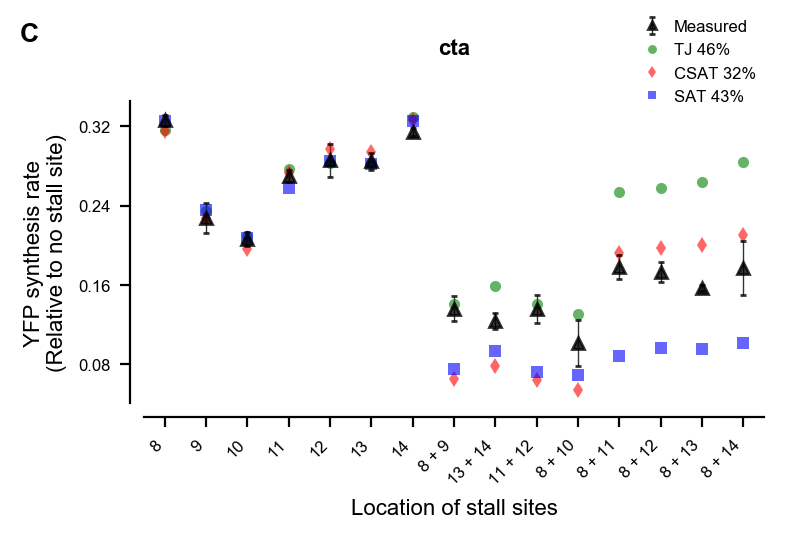

In [12]:
mutants = ['cta', '']

'''
# Uncomment this region if run_simulations_based_on_experiment_fits.ipynb
# was run to generate new simulation data

simulationdata = simulation_utils.get_simulation_data(runnumber=11)

simulationdata.drop(
    ['files'], axis=1).to_csv(
        '../rawdata/simulations/run11_data.tsv', sep='\t', index_label='index')
'''

simulationdata = pd.read_table(
    '../rawdata/simulations/run11_data.tsv', index_col=0)

pretermtypes = ['5primepreterm', 'selpreterm']

fig = plt.figure()
fig.set_size_inches([4, 3 * len(mutants)])
fig.subplots_adjust(wspace=1, hspace=1)

panellabels = iter(['C', ''])
axcount = 0
for mutant in mutants[:-1]:
    rmserror = dict()
    axcount += 1
    ax = fig.add_subplot(len(mutants), 1, axcount)

    summarydata = pd.read_table(
        '../processeddata/platereader/measured_yfprates_' + mutant +
        '_distance_mutants.tsv')
    summarydata['pauselocation'] = summarydata['pauselocation'].apply(
        lambda x: x.split(','))
    summarydata['mutant'] = summarydata.apply(get_mutant, axis=1)
    summarydata['sortcolumn'] = summarydata['pauselocation'].apply(
        return_interpausedistance_for_ordering)
    summarydata = summarydata.sort_values(by=['sortcolumn'])
    summarydata = summarydata.set_index('mutant')

    # make xtick labels nice
    xticklabels = []
    for location in summarydata['pauselocation']:
        xticklabels.append(' + '.join(sorted(location, key=int)))

    for pretermtype in pretermtypes:
        pretermrates = np.unique(simulationdata[pretermtype])
        for pretermrate in pretermrates:
            fitresults = dict()
            if pretermtype == 'selpreterm' and pretermrate == 0:
                continue
            subset = simulationdata[(simulationdata[
                pretermtype] == pretermrate) & (simulationdata['mutant'].apply(
                    lambda string: string.find(mutant.lower()) != -1))]
            model = pretermtype
            # if pretermrate is 0, make sure all other preterm rates are also 0
            if pretermrate == 0:
                for innerpretermtype in pretermtypes:
                    if innerpretermtype == pretermtype:
                        continue
                    subset = subset[(subset[innerpretermtype] == 0)]
                    model = 'trafficjam'
            subset = subset.set_index('mutant')
            subset.index = map(return_mutant_for_ordering, subset.index)
            subset = subset.ix[summarydata.index]
            predicted = np.array(subset['ps_ratio'])[7:]
            measured = np.array(summarydata['starverate_mean'])[7:]
            rmserror[model] = int(
                np.sqrt(mean_squared_error(measured, predicted)) /
                measured.mean() * 100)

            ax.plot(
                np.arange(
                    len(subset)),  # no simulation data for No Stall control
                subset['ps_ratio'],
                marker=modelmarkers[model],
                linestyle='None',
                markerfacecolor=modelcolors[model],
                alpha=0.6,
                markeredgecolor='None',
                label=modellabels[model] + " %d%%" % rmserror[model])

    ax.errorbar(
        x=np.arange(len(summarydata)),
        y=summarydata['starverate_mean'],
        yerr=summarydata[('starverate_err')],
        marker='^',
        linestyle='None',
        color='black',
        linewidth=0.5,
        markeredgecolor='black',
        label='Measured',
        alpha=0.8,
        capsize=1.0, )
    ax.set(xlabel='Location of stall sites',
           ylabel='YFP synthesis rate\n(Relative to no stall site)')
    clean_axis(ax)
    ax.yaxis.set(major_locator=MaxNLocator(5))
    ax.set_xlim(left=-0.5, right=len(summarydata) - 0.5)
    ax.set_xticks(np.arange(len(summarydata)))
    ax.set_xticklabels(
        xticklabels,
        rotation=45,
        ha='right', )
    handles, legendlabels = ax.get_legend_handles_labels()
    handles = [handles[n] for n in [3, 0, 1, 2]]
    legendlabels = [legendlabels[n] for n in [3, 0, 1, 2]]
    ax.legend(handles, legendlabels, loc=1, bbox_to_anchor=(1, 1.3))
    ax.set_title(mutant, y=1.1, weight='bold')
    ax.text(
        -0.2,
        1.2,
        panellabels.next(),
        weight='bold',
        transform=ax.transAxes,
        fontsize='large')

fig.savefig('../figures/fig6.svg')

### Plot Fig. 6--Figure supplement 1

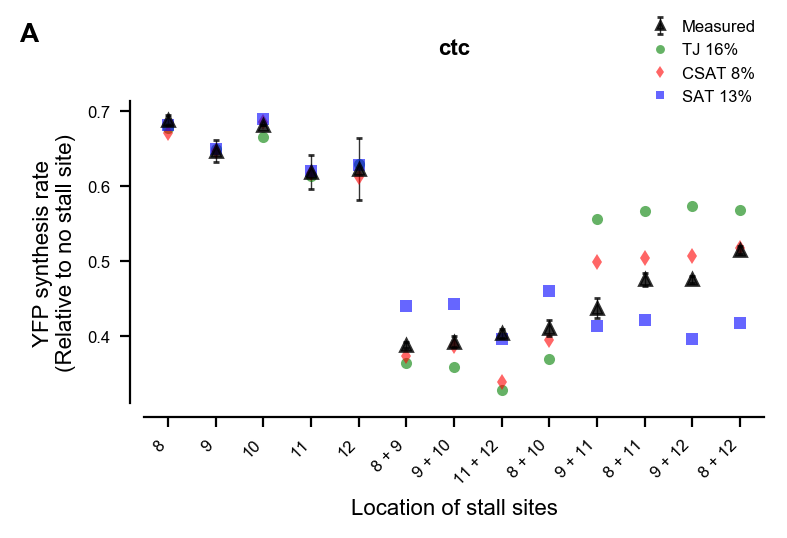

In [13]:
mutants = ['ctc', '']

'''
# Uncomment this region if run_simulations_based_on_experiment_fits.ipynb
# was run to generate new simulation data

simulationdata = simulation_utils.get_simulation_data(runnumber=5)

simulationdata.drop(
    ['files'], axis=1).to_csv(
        '../rawdata/simulations/run5_data.tsv', sep='\t', index_label='index')
'''

simulationdata = pd.read_table(
    '../rawdata/simulations/run5_data.tsv', index_col=0)

pretermtypes = ['5primepreterm', 'selpreterm']

fig = plt.figure()
fig.set_size_inches([4, 3 * len(mutants)])
fig.subplots_adjust(wspace=1, hspace=1)

panellabels = iter(['A', 'B'])
axcount = 0
for mutant in mutants[:-1]:
    rmserror = dict()
    axcount += 1
    ax = fig.add_subplot(len(mutants), 1, axcount)

    summarydata = pd.read_table(
        '../processeddata/platereader/measured_yfprates_' + mutant +
        '_distance_mutants.tsv')
    summarydata['pauselocation'] = summarydata['pauselocation'].apply(
        lambda x: x.split(','))
    summarydata['mutant'] = summarydata.apply(get_mutant, axis=1)
    summarydata['sortcolumn'] = summarydata['pauselocation'].apply(
        return_interpausedistance_for_ordering)
    summarydata = summarydata.sort_values(by=['sortcolumn'])
    summarydata = summarydata.set_index('mutant')

    # make xtick labels nice
    xticklabels = []
    for location in summarydata['pauselocation']:
        xticklabels.append(' + '.join(sorted(location, key=int)))

    for pretermtype in pretermtypes:
        pretermrates = np.unique(simulationdata[pretermtype])
        for pretermrate in pretermrates:
            fitresults = dict()
            if pretermtype == 'selpreterm' and pretermrate == 0:
                continue
            subset = simulationdata[(simulationdata[
                pretermtype] == pretermrate) & (simulationdata['mutant'].apply(
                    lambda string: string.find(mutant.lower()) != -1))]
            model = pretermtype
            # if pretermrate is 0, make sure all other preterm rates are also 0
            if pretermrate == 0:
                for innerpretermtype in pretermtypes:
                    if innerpretermtype == pretermtype:
                        continue
                    subset = subset[(subset[innerpretermtype] == 0)]
                    model = 'trafficjam'
            subset = subset.set_index('mutant')
            subset.index = map(return_mutant_for_ordering, subset.index)
            subset = subset.ix[summarydata.index]
            predicted = np.array(subset['ps_ratio'])[5:]
            measured = np.array(summarydata['starverate_mean'])[5:]
            rmserror[model] = int(
                np.sqrt(mean_squared_error(measured, predicted)) /
                measured.mean() * 100)

            ax.plot(
                np.arange(
                    len(subset)),  # no simulation data for No Stall control
                subset['ps_ratio'],
                marker=modelmarkers[model],
                linestyle='None',
                markerfacecolor=modelcolors[model],
                alpha=0.6,
                markeredgecolor='None',
                label=modellabels[model] + " %d%%" % rmserror[model])

    ax.errorbar(
        x=np.arange(len(summarydata)),
        y=summarydata['starverate_mean'],
        yerr=summarydata[('starverate_err')],
        marker='^',
        linestyle='None',
        color='black',
        linewidth=0.5,
        markeredgecolor='black',
        label='Measured',
        alpha=0.8,
        capsize=1.0, )
    ax.set(xlabel='Location of stall sites',
           ylabel='YFP synthesis rate\n(Relative to no stall site)')
    clean_axis(ax)
    ax.yaxis.set(major_locator=MaxNLocator(5))
    ax.set_xlim(left=-0.5, right=len(summarydata) - 0.5)
    ax.set_xticks(np.arange(len(summarydata)))
    ax.set_xticklabels(
        xticklabels,
        rotation=45,
        ha='right', )
    handles, legendlabels = ax.get_legend_handles_labels()
    handles = [handles[n] for n in [3, 0, 1, 2]]
    legendlabels = [legendlabels[n] for n in [3, 0, 1, 2]]
    ax.legend(handles, legendlabels, loc=1, bbox_to_anchor=(1, 1.3))
    ax.set_title(mutant, y=1.1, weight='bold')
    ax.text(
        -0.2,
        1.2,
        panellabels.next(),
        weight='bold',
        transform=ax.transAxes,
        fontsize='large')

fig.savefig('../figures/fig6_s1.svg')

### Plot Fig. 7A top panel

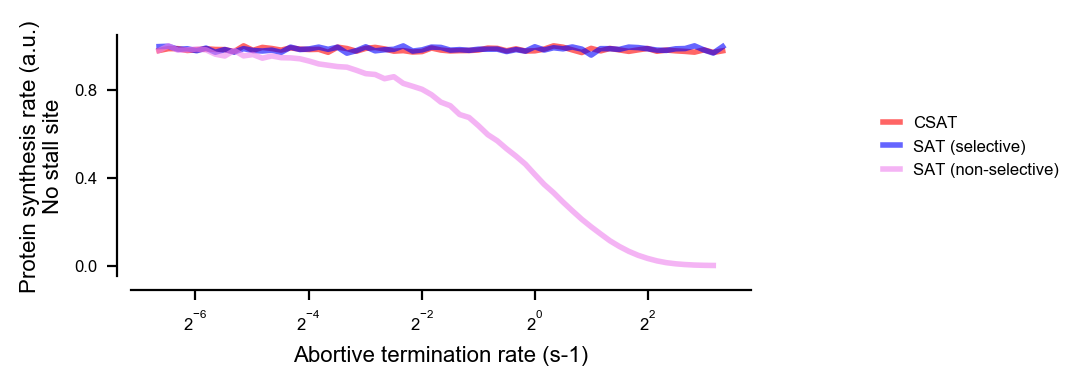

In [14]:
'''
# Uncomment this region if run_simulations_based_on_experiment_fits.ipynb
# was run to generate new simulation data

simulationdata = simulation_utils.get_simulation_data(runnumber=9)

simulationdata.drop(
    ['files'], axis=1).to_csv(
        '../rawdata/simulations/run9_data.tsv', sep='\t', index_label='index')
'''

simulationdata = pd.read_table(
    '../rawdata/simulations/run9_data.tsv', index_col=0)

pretermtypes = ['5primepreterm', 'selpreterm', 'bkgdpreterm']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for pretermtype in pretermtypes:
    subset = simulationdata[(simulationdata[pretermtype] != 0)]
    model = pretermtype
    sortedindices = sorted(
        subset.index, key=lambda x: subset.ix[x][pretermtype])
    subset = subset.ix[sortedindices]
    #subset = subset[2:-2]
    temp = ax.semilogx(
        subset[pretermtype],
        subset['proteins_yfp0'] / subset['proteins_yfp0'].max() /
        subset['simulation_time'] * subset['simulation_time'].min(),
        '-',
        label=modellabels[model],
        marker='None',
        color=modelcolors[model],
        alpha=0.6,
        basex=2)
    if pretermtype == 'selpreterm':
        temp[0].set_label(modellabels[model] + ' (selective)')
    if pretermtype == 'bkgdpreterm':
        temp[0].set_label(modellabels[model] + ' (non-selective)')
clean_axis(ax)
ax.legend(loc=2, bbox_to_anchor=(1.2, 0.7))
ax.yaxis.set(major_locator=MaxNLocator(3))
ax.set(
    xlabel=u'Abortive termination rate (s-1)',
    ylabel='Protein synthesis rate (a.u.)\nNo stall site', )
fig.set_size_inches([4, 1.6])
fig.savefig('../figures/fig7a_top.svg')

### Plot Fig. 7A bottom panel

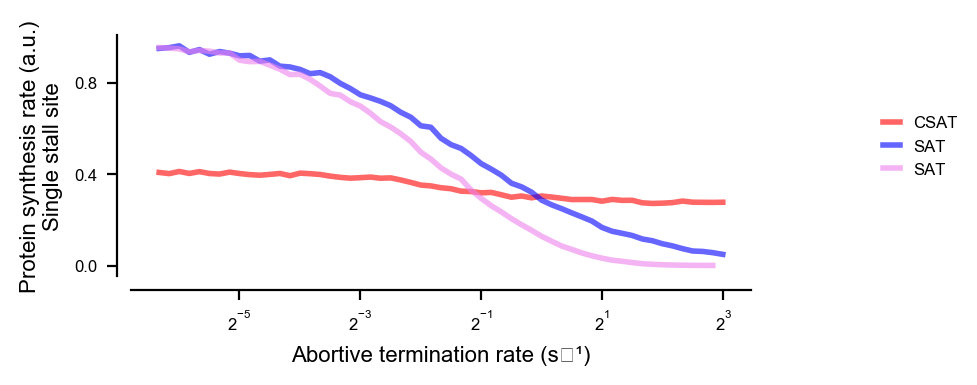

In [15]:
'''
# Uncomment this region if run_simulations_based_on_experiment_fits.ipynb
# was run to generate new simulation data

simulationdata = simulation_utils.get_simulation_data(runnumber=9)
'''

simulationdata = pd.read_table(
    '../rawdata/simulations/run9_data.tsv', index_col=0)

pretermtypes = ['5primepreterm', 'selpreterm', 'bkgdpreterm']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for pretermtype in pretermtypes:
    subset = simulationdata[(simulationdata[pretermtype] != 0)]
    model = pretermtype
    sortedindices = sorted(
        subset.index, key=lambda x: subset.ix[x][pretermtype])
    subset = subset.ix[sortedindices]
    subset = subset[2:-2]
    ax.semilogx(
        subset[pretermtype],
        subset['proteins_mutant'] / subset['proteins_yfp0'].max() /
        subset['simulation_time'] * subset['simulation_time'].min(),
        '-',
        label=modellabels[model],
        marker='None',
        color=modelcolors[model],
        alpha=0.6,
        basex=2)

    if pretermtype == 'selpreterm':
        ax.set_label(modellabels[model] + ' (selective)')
    if pretermtype == 'bkgdpreterm':
        ax.set_label(modellabels[model] + ' (non-selective)')

clean_axis(ax)
ax.legend(loc=2, bbox_to_anchor=(1.2, 0.7))
ax.yaxis.set(major_locator=MaxNLocator(3))
ax.set(
    xlabel=u'Abortive termination rate (s⁻¹)',
    ylabel='Protein synthesis rate (a.u.)\nSingle stall site', )
fig.set_size_inches([4, 1.6])
fig.savefig('../figures/fig7a_bottom.svg')

### Plot Fig. 7B

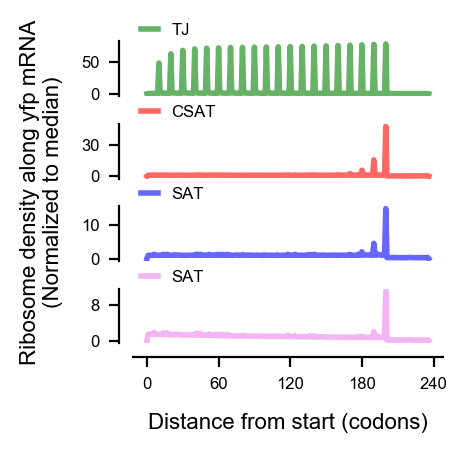

In [16]:

# Uncomment this region if run_simulations_based_on_experiment_fits.ipynb
# was run to generate new simulation data
'''
simulationdata = simulation_utils.get_simulation_data(
    runnumber=9, ribodensity=True)

'''
# Comment this region if new simulation data was generated
simulationdata = pd.read_table(
    '../rawdata/simulations/run9_data.tsv', index_col=0)


fig = plt.figure()
fig.set_size_inches([2, 2])
# common axis below used for a shared x and y label across panels 
commonaxis = plt.axes(frameon=False)
commonaxis.set_xticks([])
commonaxis.set_yticks([])
commonaxis.yaxis.labelpad = 25  # move the labels a bit away from panels
commonaxis.xaxis.labelpad = 25  # move the labels a bit away from panels
commonaxis.set(
    xlabel='Distance from start (codons)',
    ylabel='Ribosome density along yfp mRNA\n(Normalized to median)', )

pretermtypes = [
    'trafficjam',
    '5primepreterm',
    'selpreterm',
    'bkgdpreterm',
]

axcount = 0
for pretermtype in pretermtypes:
    axcount += 1
    subset = simulationdata[(simulationdata['mutant'] == 'cta18')]
    model = pretermtype
    if pretermtype == 'trafficjam':
        for innerpretermtype in pretermtypes:
            if innerpretermtype == pretermtype:
                continue
            subset = subset[subset[innerpretermtype] == 0]
        # this choice ensures that the traffic jam model is considered
        # as the limit of the CSAT model.
        subset = subset.reset_index().ix[2]
    else:
        subset = subset[subset[pretermtype] == 1.0]
        subset = subset.reset_index().ix[0]
    ribodensityfile = ('../rawdata/simulations/run9_' + pretermtype +
                       '_ribodensity_mutant.csv')
    if 'ribodensity_mutant' not in subset:  # using pre-run simulation
        subset['ribodensity_mutant'] = np.array(
            open(ribodensityfile).read().strip().split(','))
    ax = fig.add_subplot(4, 1, axcount)
    normalization = np.median(subset['ribodensity_mutant'].astype(float))
    ax.plot(
        np.arange(len(subset['ribodensity_mutant'])),
        subset['ribodensity_mutant'].astype(float) / normalization,
        label=modellabels[pretermtype],
        color=modelcolors[pretermtype],
        alpha=0.6)
    if pretermtype == 'selpreterm':
        ax.set_label(modellabels[model] + ' (selective)')
    if pretermtype == 'bkgdpreterm':
        ax.set_label(modellabels[model] + ' (non-selective)')
    clean_axis(ax)
    ax.xaxis.set(major_locator=MaxNLocator(5))
    ax.yaxis.set(major_locator=MaxNLocator(2))
    if axcount != len(pretermtypes):
        ax.xaxis.set_visible(False)
        [
            spine.set_color('none') for loc, spine in ax.spines.items()
            if loc in ['bottom']
        ]
    ax.legend(loc=2, bbox_to_anchor=(0, 1.5))
    fh = open(ribodensityfile, 'w')
    output = ','.join(subset['ribodensity_mutant']) + '\n'
    fh.write(output)
    fh.close()
fig.savefig('../figures/fig7b.svg')